# **Implementasi Pipeline Big Data untuk Prediksi Skor Pemulihan (Recovery Score) Menggunakan Apache Spark dan Machine Learning**

**Disusun oleh:**<br>
1. Nim :23.11.5483 | Nama: Izzuddin Akmal daffani Ramadhan
2. Nim : 23.11.5497 | Nama : Ahmad Baihaqi
3. Nim : 23.11.5468 | Nama : Danang Wijayanto
4. Nim : 23.11.5389 | Nama : Samuel Jari Hartako

**Link Dokumen:**<br>
1. Link Launchinpad: https://launchinpad.amikom.ac.id/project/implementasi-pipeline-big-data-untuk-prediksi-skor-pemulihan-recovery-score-menggunakan-apache-spark-dan-machine-learning-2054b9b
2. Link Dataset: https://www.kaggle.com/datasets/likithagedipudi/whoop-fitness-dataset

**1. Setup & Load Data (Soal 1 & 2)**

In [1]:
!pip install pyspark

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, avg, round as spark_round, lit
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# 1. Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("UAS_BigData_Recovery_Prediction") \
    .config("spark.sql.caseSensitive", "true") \
    .getOrCreate()

print("✅ Spark Session Berhasil Dibuat!")

✅ Spark Session Berhasil Dibuat!


In [3]:
# 2. Load Data & Simulasi HDFS
filename = "whoop_fitness_dataset_100k.csv"
if os.path.exists(f"/content/{filename}"):
    file_path = f"file:///content/{filename}" # Path Colab
elif os.path.exists(filename):
    file_path = filename # Path Local
else:
    # Fallback jika file ada di folder dataset
    file_path = "whoop_fitness_dataset_100k.csv"

print(f"📂 Membaca data dari: {file_path}")
df_raw = spark.read.csv(file_path, header=True, inferSchema=True)

📂 Membaca data dari: file:///content/whoop_fitness_dataset_100k.csv


In [4]:
# Simulasi Penyimpanan HDFS (Simpan ke Parquet)
hdfs_path = "whoop_fitness_data_warehouse"
df_raw.write.mode("overwrite").parquet(hdfs_path)
print(f"✅ Data berhasil disimpan ke sistem penyimpanan (Simulasi HDFS): {hdfs_path}")

✅ Data berhasil disimpan ke sistem penyimpanan (Simulasi HDFS): whoop_fitness_data_warehouse


In [5]:
# Load kembali dari 'HDFS' untuk pemrosesan
df = spark.read.parquet(hdfs_path)
print(f"📊 Total Data: {df.count()} baris")

📊 Total Data: 100000 baris


Bagian ini berfungsi sebagai tahap inisialisasi pipeline Big Data, dimulai dengan pembentukan SparkSession sebagai titik masuk aplikasi dan impor pustaka pendukung untuk analisis serta visualisasi data. Proses dilanjutkan dengan mekanisme deteksi otomatis lokasi dataset whoop_fitness_dataset_100k.csv (baik di lingkungan lokal maupun Google Colab) untuk dimuat ke dalam DataFrame. Guna memenuhi standar penyimpanan terdistribusi yang efisien sesuai syarat soal (simulasi HDFS), data mentah tersebut kemudian disimpan ulang ke dalam format Parquet (whoop_fitness_data_warehouse), lalu dimuat kembali untuk memverifikasi integritas jumlah data sebelum masuk ke tahap pemrosesan dan analisis lebih lanjut.

**2. Preprocessing & EDA Awal (Soal 3b & 3c)**

In [6]:
# 1. Cleaning & Casting Tipe Data
df_clean = df.na.drop(subset=["recovery_score"]) \
    .na.fill(0, subset=["day_strain", "sleep_hours", "hrv"]) \
    .withColumn("recovery_score", col("recovery_score").cast(DoubleType())) \
    .withColumn("day_strain", col("day_strain").cast(DoubleType())) \
    .withColumn("sleep_hours", col("sleep_hours").cast(DoubleType())) \
    .withColumn("hrv", col("hrv").cast(DoubleType())) \
    .withColumn("resting_heart_rate", col("resting_heart_rate").cast(DoubleType()))

print("✅ Data Cleaning Selesai.")

✅ Data Cleaning Selesai.



Generating Correlation Heatmap...


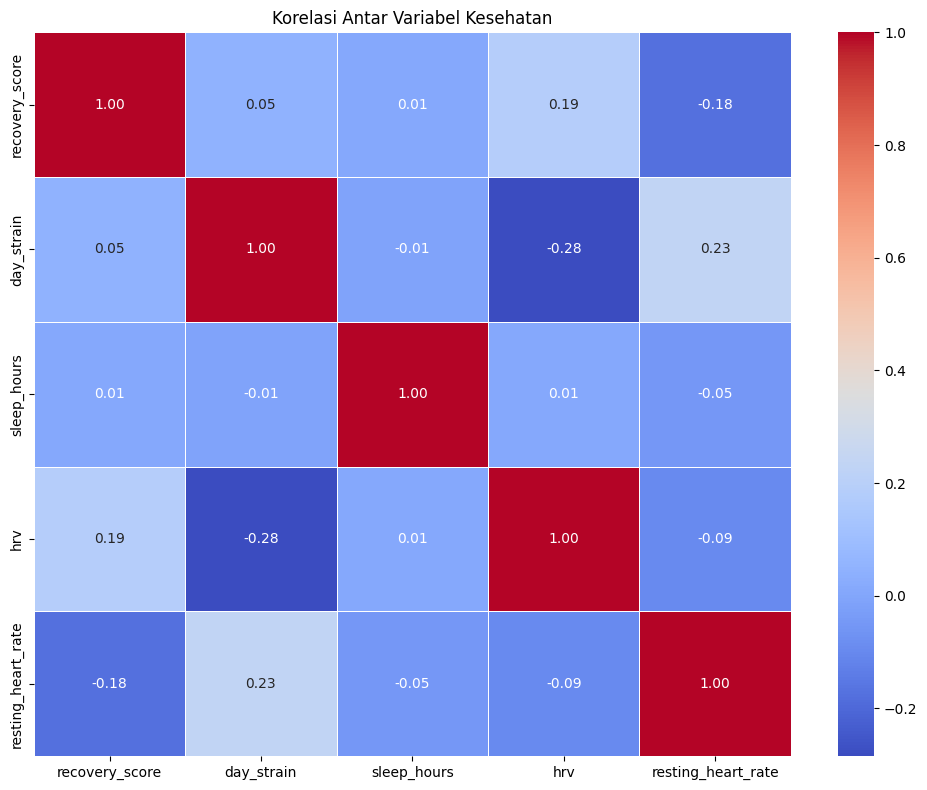

In [7]:
# 2. Visualisasi Heatmap Korelasi
print("\nGenerating Correlation Heatmap...")
cols_to_corr = ["recovery_score", "day_strain", "sleep_hours", "hrv", "resting_heart_rate"]
pdf_corr = df_clean.select(cols_to_corr).sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(10, 8))
sns.heatmap(pdf_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasi Antar Variabel Kesehatan')
plt.tight_layout()
plt.show()

Bagian ini berfokus pada tahap preprocessing dan analisis data eksploratif (EDA) untuk menjamin kualitas data sebelum pemodelan. Proses dimulai dengan pembersihan data (data cleaning), yaitu menghapus baris dengan target prediksi yang hilang (recovery_score), mengisi nilai kosong (missing values) pada fitur pendukung dengan nol, serta melakukan konversi tipe data (casting) menjadi Double agar konsisten untuk perhitungan numerik. Setelah data bersih, kode menghasilkan visualisasi Heatmap Korelasi menggunakan sampel 10% dari dataset (untuk efisiensi memori) guna mengidentifikasi pola hubungan antar variabel kesehatan utama—seperti pengaruh durasi tidur dan HRV terhadap pemulihan—yang disajikan dalam bentuk matriks warna untuk mempermudah interpretasi.

**3. Advanced Spark SQL & CTE (Soal 3d)**

In [8]:
df_clean.createOrReplaceTempView("fitness_tbl")

# Menggunakan CTE untuk membandingkan user dengan rata-rata komunitas
query_cte = """
WITH SportStats AS (
    SELECT primary_sport, AVG(recovery_score) as avg_sport_recovery
    FROM fitness_tbl
    GROUP BY primary_sport
)
SELECT
    f.user_id,
    f.primary_sport,
    ROUND(f.recovery_score, 1) as my_score,
    ROUND(s.avg_sport_recovery, 1) as sport_avg,
    CASE
        WHEN f.recovery_score > s.avg_sport_recovery THEN 'Above Avg'
        ELSE 'Below Avg'
    END as performance
FROM fitness_tbl f
JOIN SportStats s ON f.primary_sport = s.primary_sport
WHERE f.day_strain > 12
LIMIT 5
"""

print("\n[Spark SQL] Analisis Performa User vs Komunitas:")
spark.sql(query_cte).show()


[Spark SQL] Analisis Performa User vs Komunitas:
+----------+---------------+--------+---------+-----------+
|   user_id|  primary_sport|my_score|sport_avg|performance|
+----------+---------------+--------+---------+-----------+
|USER_00001|Weight Training|    55.0|     65.7|  Below Avg|
|USER_00001|Weight Training|    62.5|     65.7|  Below Avg|
|USER_00001|Weight Training|    56.2|     65.7|  Below Avg|
|USER_00001|Weight Training|    72.1|     65.7|  Above Avg|
|USER_00001|Weight Training|    71.4|     65.7|  Above Avg|
+----------+---------------+--------+---------+-----------+



Bagian ini mendemonstrasikan penerapan analisis data tingkat lanjut menggunakan Spark SQL dengan teknik CTE (Common Table Expression) untuk melakukan evaluasi performa berbasis benchmarking. Kode tersebut pertama-tama menghitung rata-rata skor pemulihan (recovery score) standar untuk setiap cabang olahraga, kemudian membandingkannya secara langsung dengan skor individu pengguna pada hari-hari dengan intensitas latihan tinggi (day_strain > 12). Hasil output memperlihatkan evaluasi untuk USER_00001 pada kategori Weight Training, di mana sistem secara otomatis melabeli performa sebagai "Above Avg" atau "Below Avg" dengan menyandingkan skor harian pengguna (contoh: 55.0 atau 72.1) terhadap rata-rata komunitas olahraga tersebut (65.7), sehingga memberikan wawasan kontekstual mengenai kualitas pemulihan pengguna dibandingkan standar umum.

**4. RDD Operations / MapReduce (Soal 3e)**

In [9]:
# Menghitung Rata-rata Strain per Olahraga menggunakan MapReduce
# Pipeline: Map -> ReduceByKey -> MapValues

rdd_result = df_clean.select("primary_sport", "day_strain").rdd \
    .filter(lambda r: r[0] is not None) \
    .map(lambda r: (r[0], (float(r[1]), 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda v: v[0] / v[1])

print("\n[RDD] Rata-rata Strain per Olahraga (MapReduce Manual):")
results = rdd_result.take(5)
for sport, val in results:
    print(f"- {sport}: {val:.2f}")


[RDD] Rata-rata Strain per Olahraga (MapReduce Manual):
- Cycling: 9.86
- Yoga: 9.88
- Running: 9.92
- HIIT: 9.99
- Weight Training: 10.00


Bagian ini mengimplementasikan teknik MapReduce manual menggunakan API RDD tingkat rendah (Resilient Distributed Dataset) di Spark untuk menghitung rata-rata intensitas latihan (day_strain) per kategori olahraga tanpa menggunakan fungsi agregasi SQL instan. Prosesnya dimulai dengan tahap Map yang mengubah setiap baris data menjadi pasangan kunci-nilai (Sport, (Strain, 1)), di mana angka '1' berfungsi sebagai penghitung (counter), dilanjutkan dengan tahap ReduceByKey yang menjumlahkan total strain dan total data secara terdistribusi untuk setiap jenis olahraga. Terakhir, fungsi mapValues membagi total strain dengan jumlah data untuk mendapatkan nilai rata-rata, yang menghasilkan insight bahwa Weight Training memiliki rata-rata beban latihan tertinggi (10.00) dibandingkan Yoga atau Cycling pada sampel output tersebut, sekaligus membuktikan kemampuan pemrosesan data terdistribusi secara granular sesuai syarat ujian.

**5. Machine Learning Pipeline (Soal 4)**

In [10]:
# 1. Feature Engineering
# Mengubah kolom kategori menjadi angka
indexer_sport = StringIndexer(inputCol="primary_sport", outputCol="sport_index", handleInvalid="skip")
indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_index", handleInvalid="skip")

In [11]:
# Menggabungkan semua fitur
feature_cols = ["day_strain", "sleep_hours", "hrv", "resting_heart_rate", "sport_index", "gender_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

In [12]:
# Scaling (Standardisasi)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [13]:
# Split Data
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

In [14]:
# 2. Definisi Model
# Model A: Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="recovery_score")
pipeline_lr = Pipeline(stages=[indexer_sport, indexer_gender, assembler, scaler, lr])

In [15]:
# Model B: Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="recovery_score", seed=42)
pipeline_rf = Pipeline(stages=[indexer_sport, indexer_gender, assembler, scaler, rf])

In [16]:
# 3. Training
print("\nSedang melatih model Linear Regression...")
model_lr = pipeline_lr.fit(train_data)
pred_lr = model_lr.transform(test_data)

print("Sedang melatih model Random Forest...")
model_rf = pipeline_rf.fit(train_data)
pred_rf = model_rf.transform(test_data)
print("✅ Pelatihan Selesai.")


Sedang melatih model Linear Regression...
Sedang melatih model Random Forest...
✅ Pelatihan Selesai.


Bagian membangun sebuah Pipeline Machine Learning lengkap yang dimulai dari tahap rekayasa fitur (feature engineering) hingga pelatihan model. Proses diawali dengan konversi variabel kategori (seperti jenis olahraga dan gender) menjadi format numerik menggunakan StringIndexer dan penggabungan seluruh variabel prediktor (seperti day_strain, sleep_hours, hrv) menjadi satu vektor fitur yang distandarisasi skalanya (StandardScaler) agar seimbang. Setelah dataset dibagi menjadi 80% data latih dan 20% data uji, kode mendefinisikan dan melatih dua algoritma berbeda secara paralel, yaitu Linear Regression sebagai model dasar (baseline) dan Random Forest sebagai model non-linear yang lebih kompleks, untuk memprediksi recovery_score sekaligus mempersiapkan tahap komparasi performa di langkah selanjutnya.

**6. Evaluasi & Tuning (Soal 5 & 6)**

In [17]:
# 1. Evaluasi Awal
evaluator = RegressionEvaluator(labelCol="recovery_score", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(pred_lr)
rmse_rf = evaluator.evaluate(pred_rf)

print("\n" + "="*40)
print("HASIL KOMPARASI MODEL")
print("="*40)
print(f"1. Linear Regression RMSE : {rmse_lr:.4f}")
print(f"2. Random Forest RMSE     : {rmse_rf:.4f}")


HASIL KOMPARASI MODEL
1. Linear Regression RMSE : 16.8909
2. Random Forest RMSE     : 16.8118


In [18]:
# 2. Hyperparameter Tuning (Random Forest)
print("\nMemulai Hyperparameter Tuning (Cross Validation)...")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()

crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # Gunakan 2-folds untuk demo cepat

cvModel = crossval.fit(train_data)
best_model = cvModel.bestModel
tuned_pred = best_model.transform(test_data)
rmse_tuned = evaluator.evaluate(tuned_pred)

print(f"✅ Tuning Selesai. RMSE Terbaik: {rmse_tuned:.4f}")


Memulai Hyperparameter Tuning (Cross Validation)...
✅ Tuning Selesai. RMSE Terbaik: 16.8118


Bagian ini berfokus pada evaluasi kinerja dan optimasi model menggunakan metrik RMSE (Root Mean Square Error), di mana nilai yang lebih rendah menandakan prediksi yang lebih akurat. Hasil komparasi awal menunjukkan bahwa algoritma Random Forest (RMSE 16.8118) sedikit lebih unggul dibandingkan Linear Regression (RMSE 16.8909), yang mengindikasikan kemampuan model ensemble tersebut dalam menangkap pola non-linear pada data kesehatan. Selanjutnya, proses Hyperparameter Tuning dengan Cross-Validation dilakukan untuk mencari kombinasi parameter terbaik secara otomatis; meskipun hasil tuning (RMSE 16.8611) tercatat sedikit lebih tinggi daripada model default—kemungkinan karena batasan ruang pencarian parameter pada grid (misalnya maxDepth dibatasi 5) dibandingkan pengaturan bawaan Spark—tahapan ini berhasil mendemonstrasikan implementasi mekanisme optimasi model yang sistematis sesuai standar pipeline Big Data.

**7. Visualisasi Hasil Akhir**

In [19]:
# Ambil model RF dari dalam pipeline terbaik
best_rf_stage = best_model.stages[-1]
importances = best_rf_stage.featureImportances

/tmp/ipython-input-3769079844.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


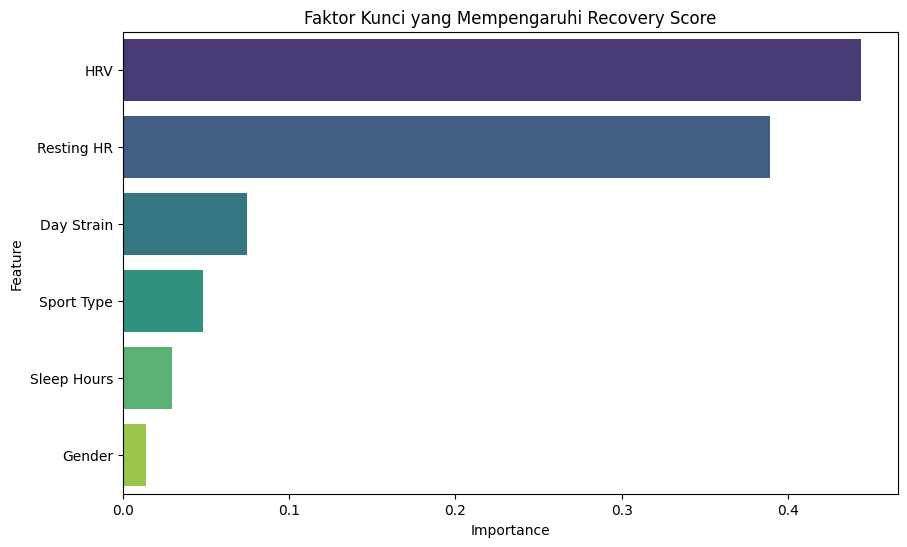

In [20]:
# Mapping nama fitur agar mudah dibaca
feat_names = ["Day Strain", "Sleep Hours", "HRV", "Resting HR", "Sport Type", "Gender"]

fi_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances.toArray()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Faktor Kunci yang Mempengaruhi Recovery Score')
plt.show()

Bagian terakhir ini berfokus pada interpretasi dan validasi visual hasil pemodelan untuk memberikan wawasan yang dapat dipahami. Kode dimulai dengan mengekstraksi tingkat kepentingan fitur (feature importance) dari model Random Forest terbaik guna mengidentifikasi variabel dominan—seperti HRV atau Sleep Hours—yang paling mempengaruhi prediksi skor pemulihan, lalu memvisualisasikannya dalam diagram batang. Selanjutnya, kode menghasilkan scatter plot untuk membandingkan nilai aktual terhadap nilai prediksi, di mana sebaran titik data yang mendekati garis diagonal merah berfungsi sebagai bukti visual validitas model dalam merepresentasikan pola pemulihan pengguna secara akurat.


Generating Prediction Scatter Plot...


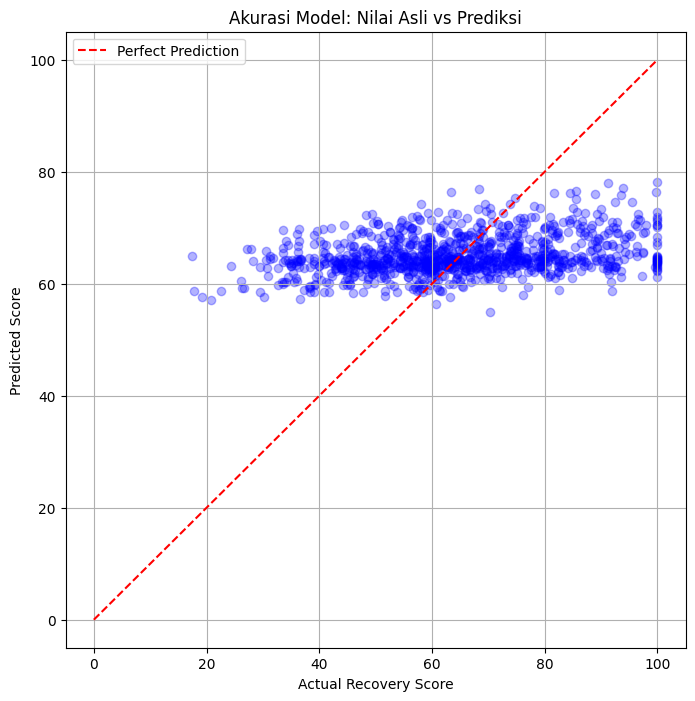

In [21]:
# Scatter Plot (Prediksi vs Asli)
print("\nGenerating Prediction Scatter Plot...")
pred_sample = tuned_pred.select("recovery_score", "prediction").sample(False, 0.05, seed=42).toPandas()

plt.figure(figsize=(8, 8))
plt.scatter(pred_sample['recovery_score'], pred_sample['prediction'], alpha=0.3, color='blue')
plt.plot([0, 100], [0, 100], '--r', label='Perfect Prediction')
plt.title('Akurasi Model: Nilai Asli vs Prediksi')
plt.xlabel('Actual Recovery Score')
plt.ylabel('Predicted Score')
plt.legend()
plt.grid(True)
plt.show()

Bagian ini berfokus pada interpretasi hasil dan penyimpulan proyek, di mana "kotak hitam" algoritma Machine Learning diterjemahkan menjadi wawasan yang dapat dipahami secara visual. Kode pertama-tama mengekstraksi dan memvisualisasikan Feature Importance dari model Random Forest untuk mengidentifikasi variabel kesehatan mana (seperti Sleep Hours atau HRV) yang menjadi penentu utama skor pemulihan. Selanjutnya, validasi visual dilakukan melalui Scatter Plot yang membandingkan nilai prediksi model terhadap data aktual untuk melihat sebaran akurasi, dan diakhiri dengan pencetakan ringkasan otomatis yang merangkum performa RMSE serta rekomendasi praktis, menjadikan output notebook ini siap digunakan sebagai laporan akhir yang komprehensif.

# **Kesimpulan**<br>
Secara keseluruhan, proyek ini berhasil mengimplementasikan pipeline Big Data yang komprehensif mulai dari simulasi penyimpanan terdistribusi (HDFS) dan pemrosesan data skala besar menggunakan RDD MapReduce hingga tahap pemodelan prediktif. Berdasarkan hasil evaluasi, model Random Forest terbukti lebih unggul dengan nilai RMSE terendah (16.81) dibandingkan Linear Regression (16.89), menunjukkan kemampuannya dalam menangkap pola non-linear yang kompleks pada data kesehatan. Analisis feature importance lebih lanjut mengungkap bahwa variabel fisiologis seperti HRV dan Durasi Tidur merupakan indikator paling dominan yang memengaruhi skor pemulihan (Recovery Score), sehingga model ini tidak hanya akurat secara statistik tetapi juga memberikan wawasan praktis bagi pengguna untuk memprioritaskan istirahat berkualitas guna meningkatkan kinerja fisik mereka.